In [48]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
RANDOM_SEED = 42
from tensorflow.keras.regularizers import l2

import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Specify each path

In [49]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [50]:
NUM_CLASSES = 5

# Dataset reading

In [51]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [52]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [56]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [57]:
# # Model compilation
# model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# Model training

In [58]:
#Define the Hyperparameter Space
def build_model(hp):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((21 * 2, )),
        tf.keras.layers.Dropout(hp.Float('dropout_rate_1', 0.1, 0.5, step=0.1)),
        tf.keras.layers.Dense(
            hp.Int('units_1', min_value=16, max_value=64, step=16),
            activation='relu',
            kernel_regularizer=l2(0.011)  # L2 regularization with a factor of 0.01
        ),
        tf.keras.layers.Dropout(hp.Float('dropout_rate_2', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(
            hp.Int('units_2', min_value=8, max_value=32, step=8),
            activation='relu',
            kernel_regularizer=l2(0.011)  # L2 regularization with a factor of 0.01
        ),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Model compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [59]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='keypoint_classifier_tuning',
    seed=RANDOM_SEED
)

Reloading Tuner from tuner_results\keypoint_classifier_tuning\tuner0.json


In [60]:
#run the search. 
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[es_callback],        

)


The optimal learning rate is 0.0009749332269823054,
The optimal units in the first dense layer is 48,
The optimal units in the second dense layer is 16,
The optimal dropout rate for the first layer is 0.1,
The optimal dropout rate for the second layer is 0.2.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)                 │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 48)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,933 (11.46 KB)

 Trainable params: 2,933 (11.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
151/179 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.3077 - loss: 2.1531
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3246 - loss: 2.1153 - val_accuracy: 0.7320 - val_loss: 1.4403
Epoch 2/1000
148/179 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.6238 - loss: 1.3992
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 1.3824 - val_accuracy: 0.8471 - val_loss: 1.0172
Epoch 3/1000
157/179 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.7366 - loss: 1.0980
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7394 - loss: 1.0905 - val_accuracy: 0.9065 - val_loss: 0.8164
Epoch 4/1000
156/179 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.7902 - loss: 0.9328
Epoch 4: saving model to model/keypoint_classifier/keypoin

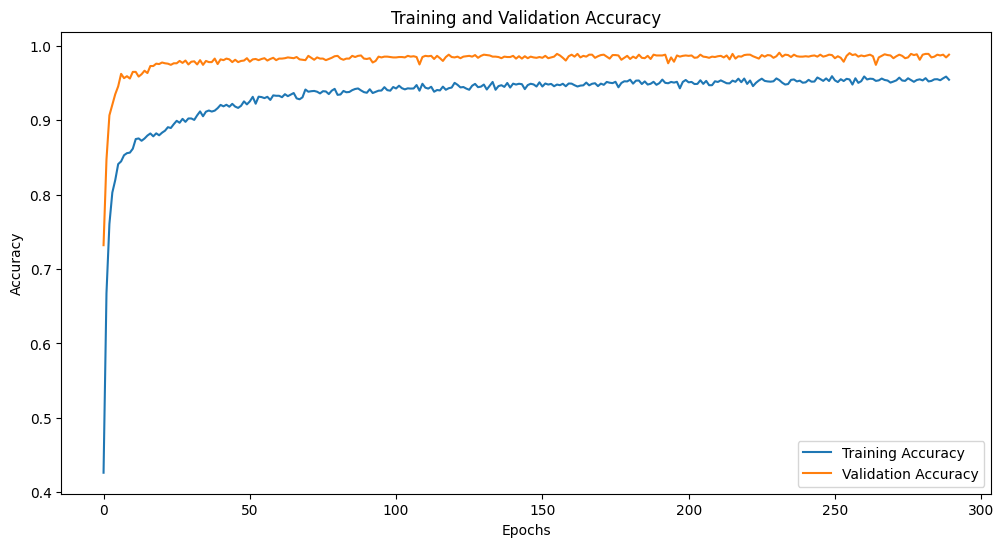

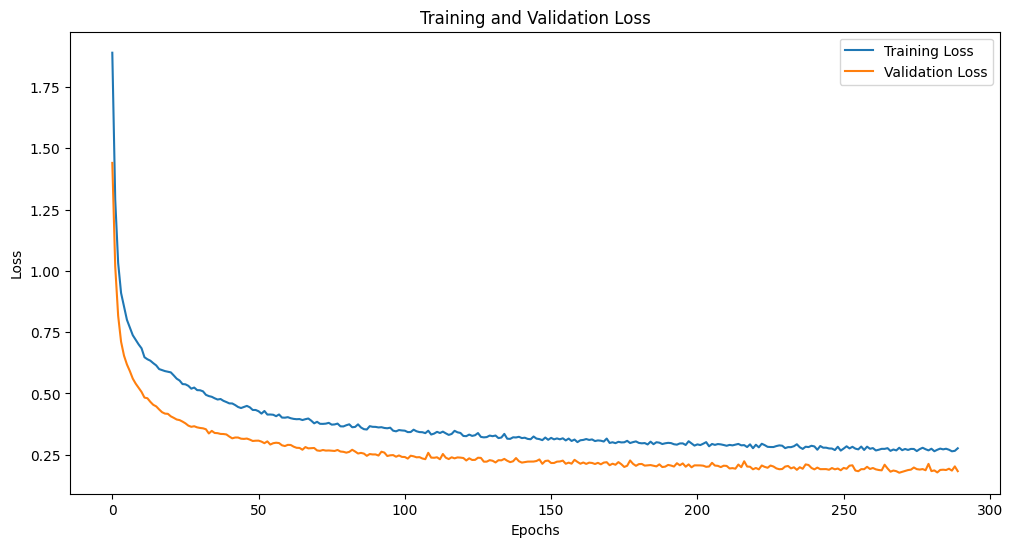

In [61]:
#After the search is complete, can get the best hyperparameters and build the model with these.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')},
The optimal units in the first dense layer is {best_hps.get('units_1')},
The optimal units in the second dense layer is {best_hps.get('units_2')},
The optimal dropout rate for the first layer is {best_hps.get('dropout_rate_1')},
The optimal dropout rate for the second layer is {best_hps.get('dropout_rate_2')}.
""")

# Rebuild the model using the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
model.summary()

#Train model with best hyperparameters
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

# Plotting accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# #5-Fold Cross-Validation
# from sklearn.model_selection import KFold
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# # Define the KFold Cross Validator
# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# # Placeholders to store results
# fold_no = 1
# acc_per_fold = []
# loss_per_fold = []

# for train, test in kfold.split(X_dataset, y_dataset):
    
#     # Build the model using the best hyperparameters found
#     model = tuner.hypermodel.build(best_hps)
    
#     # Define callbacks (re-use cp_callback and es_callback if already defined)
#     checkpoint_path = f'model/keypoint_classifier/cv_fold_{fold_no}.keras'
#     cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=False)
#     es_callback = EarlyStopping(patience=20, verbose=1)
    
#     print(f'Training for fold {fold_no} ...')
    
#     # Fit data to model
#     history = model.fit(X_dataset[train], y_dataset[train],
#                         epochs=1000,
#                         validation_data=(X_dataset[test], y_dataset[test]),
#                         callbacks=[cp_callback, es_callback])
    
#     # Generate generalization metrics
#     scores = model.evaluate(X_dataset[test], y_dataset[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
    
#     # Increase fold number
#     fold_no += 1

# # == Provide a summary ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#   print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')
# # 


# # ////////////////////////////////////////////////////////////////////////////
# # # 1. Import the necessary libraries for K-Fold Cross-Validation
# from sklearn.model_selection import KFold
# from sklearn.metrics import accuracy_score

# # 2. Set up the K-Fold Cross-Validation
# kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# fold_no = 1
# accuracies = []

# for train_index, val_index in kf.split(X_dataset):
#     print(f"Training on Fold {fold_no}...")
    
#     # Split data
#     X_train, X_val = X_dataset[train_index], X_dataset[val_index]
#     y_train, y_val = y_dataset[train_index], y_dataset[val_index]
    
#     # 3. Build and compile the model using the optimal hyperparameters
#     model = tuner.hypermodel.build(best_hps)
    
#     # Train the model on the current fold
#     history = model.fit(
#         X_train,
#         y_train,
#         epochs=1000,
#         validation_data=(X_val, y_val),
#         callbacks=[es_callback],
#         verbose=0  # Suppress detailed log output for cleaner output
#     )
    
#     # Evaluate the model on the validation set
#     val_loss, val_acc = model.evaluate(X_val, y_val, batch_size=128, verbose=0)
#     accuracies.append(val_acc)
    
#     print(f"Fold {fold_no} - Validation Accuracy: {val_acc}")
#     fold_no += 1

# # 4. Print the cross-validation results
# print(f"\nCross-Validation Results: {accuracies}")
# print(f"Mean Accuracy: {np.mean(accuracies)}")
# print(f"Standard Deviation: {np.std(accuracies)}")


Epoch 1/100
 1/48 ━━━━━━━━━━━━━━━━━━━━ 29s 635ms/step - accuracy: 0.1328 - loss: 2.6365
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2413 - loss: 2.3613 - val_accuracy: 0.5302 - val_loss: 1.9474
Epoch 2/100
 1/48 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3438 - loss: 2.0310
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 1.9025 - val_accuracy: 0.6958 - val_loss: 1.5991
Epoch 3/100
 1/48 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5469 - loss: 1.6417
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5880 - loss: 1.5843 - val_accuracy: 0.7654 - val_loss: 1.3115
Epoch 4/100
 1/48 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6562 - loss: 1.3822
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
4

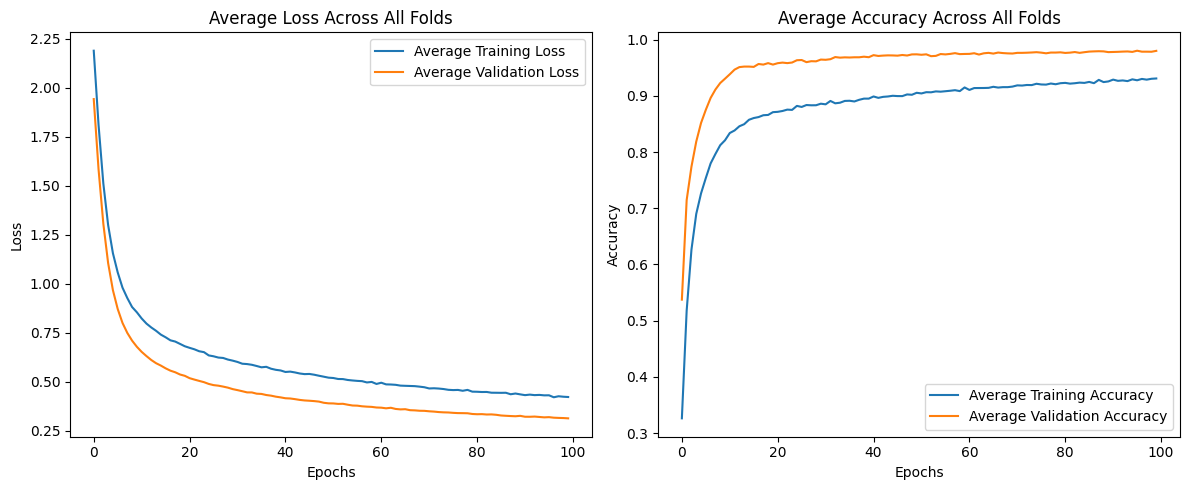

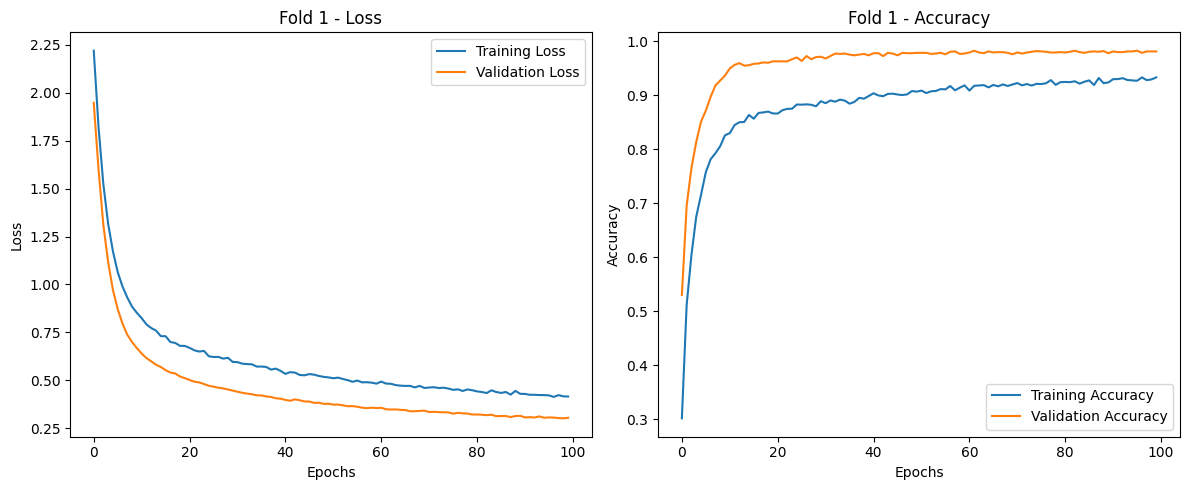

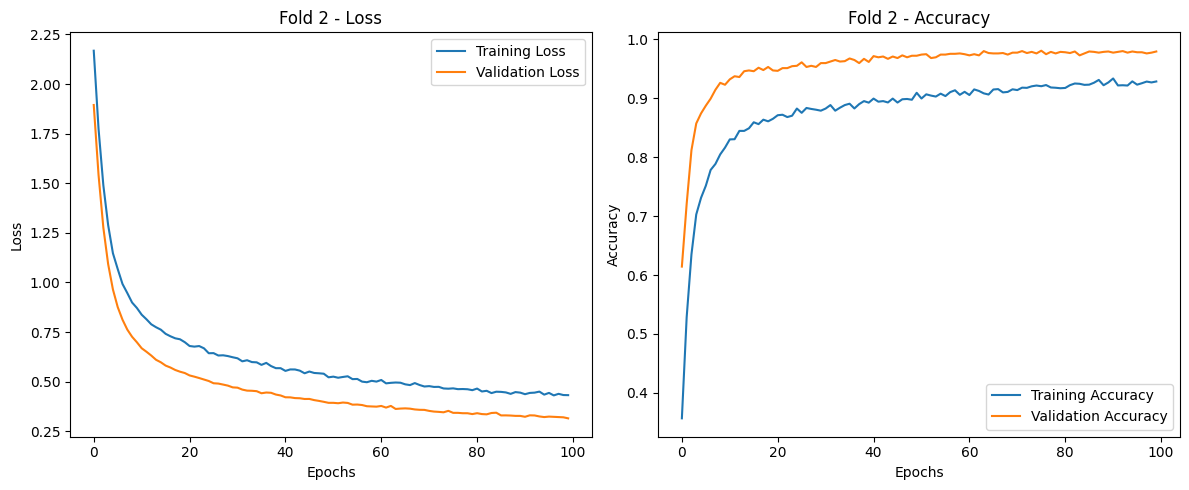

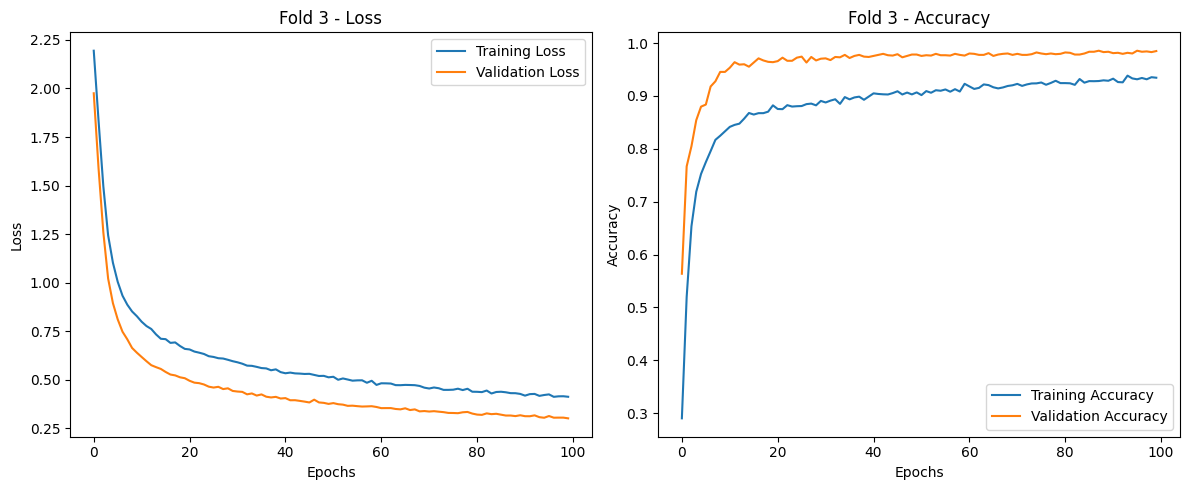

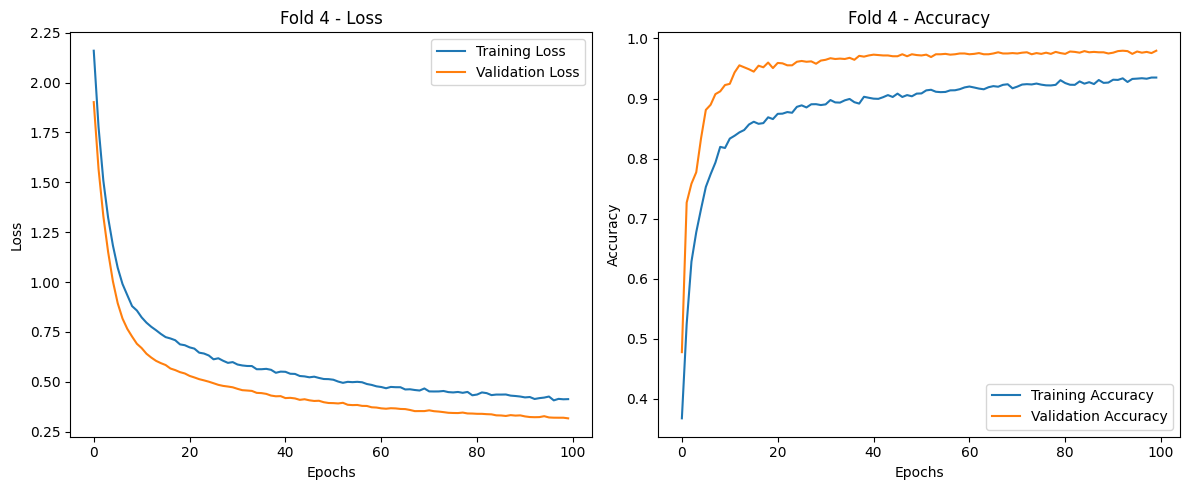

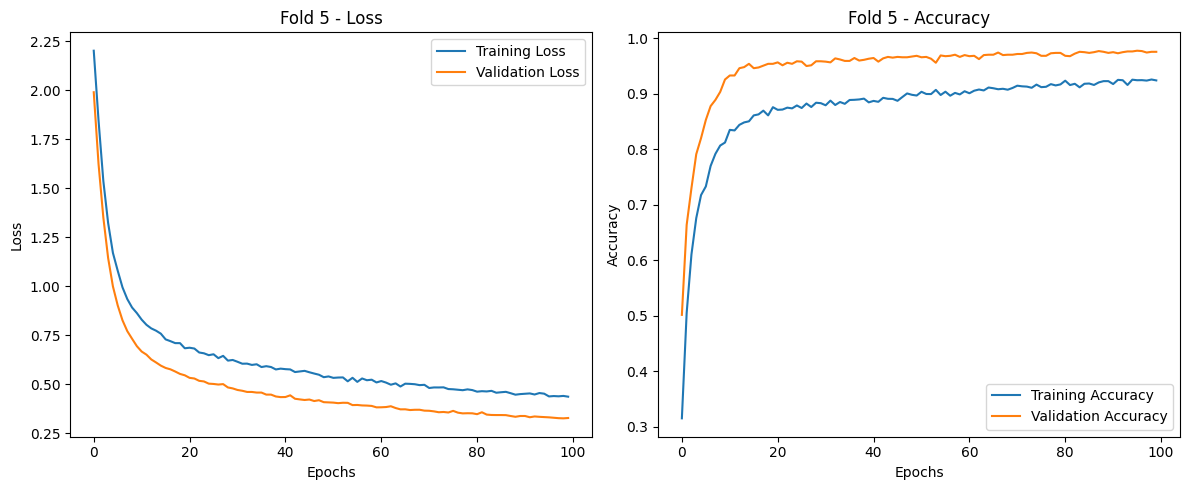

In [16]:
###################################
# # Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
histories = []  # To store the history of each fold

for train_index, test_index in kf.split(X_dataset):
    X_train, X_test = X_dataset[train_index], X_dataset[test_index]
    y_train, y_test = y_dataset[train_index], y_dataset[test_index]

    model = tuner.hypermodel.build(best_hps)
    # Train the model with validation data
    history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), callbacks=[cp_callback])
    
    # Store history for later use
    histories.append(history)
    
    # Predict on the test set
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

# Calculate average scores across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')

# Aggregating metrics across all folds for plotting
avg_train_loss = np.zeros(100)
avg_val_loss = np.zeros(100)
avg_train_accuracy = np.zeros(100)
avg_val_accuracy = np.zeros(100)

for history in histories:
    avg_train_loss += np.array(history.history['loss'])
    avg_val_loss += np.array(history.history['val_loss'])
    avg_train_accuracy += np.array(history.history['accuracy'])
    avg_val_accuracy += np.array(history.history['val_accuracy'])

# Averaging over the number of folds
avg_train_loss /= len(histories)
avg_val_loss /= len(histories)
avg_train_accuracy /= len(histories)
avg_val_accuracy /= len(histories)

# Plotting the aggregated loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Average Loss Across All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Accuracy Across All Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Individual plots for each fold
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 5))  # Create a new figure for each fold with adequate size
    
    # Plotting the loss curves
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the accuracy curves
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i+1} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()

In [17]:
#Summarize Results in a Table

import pandas as pd

results_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

print(results_df)


   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.981603   0.981700  0.981603  0.981622
1     2  0.979632   0.979700  0.979632  0.979615
2     3  0.984888   0.985016  0.984888  0.984896
3     4  0.979632   0.979898  0.979632  0.979591
4     5  0.975690   0.976089  0.975690  0.975680


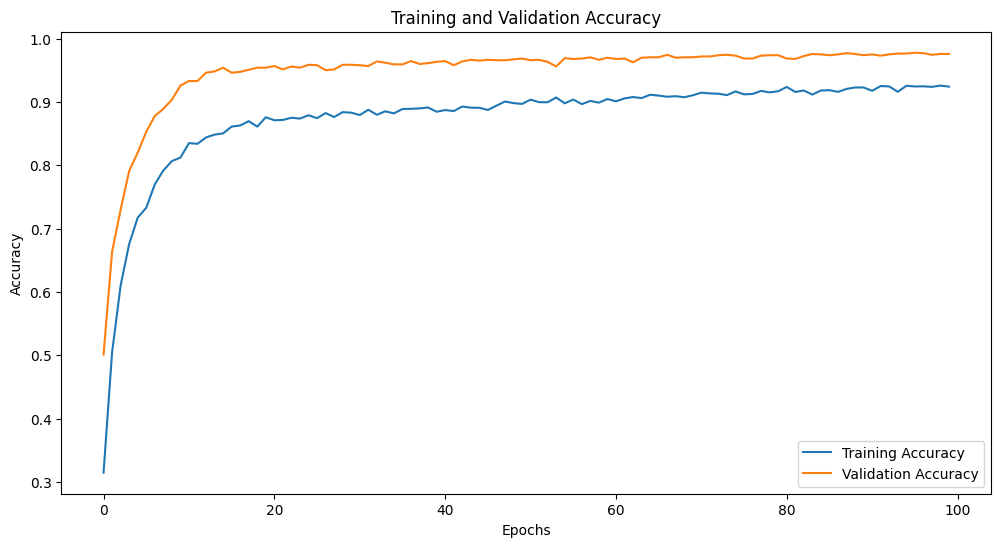

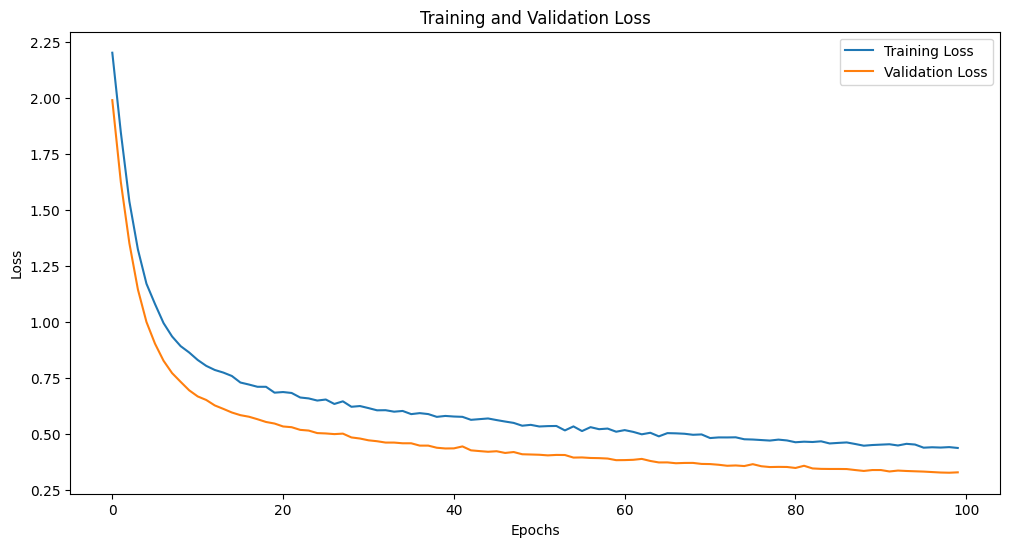

In [20]:
# Plotting accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [21]:
#Evaluate the model and save it as before
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)


# Save the model
model.save(model_save_path)

# Convert the model to TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open(tflite_save_path, 'wb') as f:
#     f.write(tflite_model)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.9661 - loss: 0.3388


In [22]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.9661 - loss: 0.3388


In [23]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

Validation Loss: 0.3275681138038635, Validation Accuracy: 0.9756898880004883


In [24]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[8.6628145e-01 1.5218813e-02 3.2004504e-04 6.2328159e-05 1.1811738e-01]
0


# Confusion matrix

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


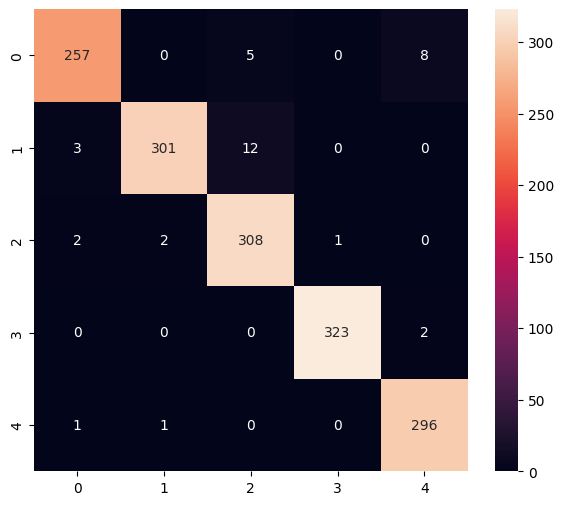

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       270
           1       0.99      0.95      0.97       316
           2       0.95      0.98      0.97       313
           3       1.00      0.99      1.00       325
           4       0.97      0.99      0.98       298

    accuracy                           0.98      1522
   macro avg       0.98      0.98      0.98      1522
weighted avg       0.98      0.98      0.98      1522



In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [26]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [27]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Jhevish\AppData\Local\Temp\tmpo_5a_s89\assets


INFO:tensorflow:Assets written to: C:\Users\Jhevish\AppData\Local\Temp\tmpo_5a_s89\assets


Saved artifact at 'C:\Users\Jhevish\AppData\Local\Temp\tmpo_5a_s89'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  1898200459120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1898200464752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1897929992576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1898199901712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1898199896432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1898199898192: TensorSpec(shape=(), dtype=tf.resource, name=None)


8448

# Inference test

In [28]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [29]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [30]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [31]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1e+03 μs


In [32]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.64914417e-01 1.46563072e-02 3.08269315e-04 6.24851018e-05
 1.20058455e-01]
0
